### **Introduction**

This is an example notebook that demonstrates how to use Alphagen to search for optimal trading strategies.

The process is as follows:

1. Define the search parameters
2. Run the search and get top individuals
3. Test for Robustness

The only part that requires user input is the first step, where we define the search parameters. The rest of the process is automated, in a sense that the user can run the search, get the top individuals and test for robustness, using simple plug-and-play functions/notebooks.

Let's dive into it.


In [1]:
import sys
sys.path.append('..')

import hyperspaces
from search import run_genetic_search

import pandas as pd
import matplotlib.pyplot as plt


### Running the Genetic Search

__Parameter Descriptions:__

- **asset**: The asset to search strategies for. Depends on the data you have, which can be either a vector (single asset search) or a matrix (multi asset search).

- **oos_timestamp**: The timestamp to use for the out-of-sample data

- **mutation_rate**: The mutation rate to use for the genetic search

- **fitness_option**: The fitness function to use for the genetic search. Please refer to the fitness_options in genetic_algorithm.py (within __init__) to view the options.

- **n_trades_threshold_option**: Boolean, whether to use a N trades threshold for the genetic search. If True, individuals with less than N trades will be skipped (fitness = NaN).

- **n_trades_threshold**: If n_trades_threshold_option is True, this is the number of trades that will be used as the threshold.

- **tournament_size**: The tournament size to use for the genetic search

- **direction**: The direction to use for the genetic search. 'L' for long only, 'S' for short only, 'LS' for long and short.

- **hyperspace**: The hyperspace to use for the genetic search. Please refer to hyperspaces.py to view the options.

- **population_size**: The population size to use for the genetic search

- **num_generations**: The number of generations to use for the genetic search

- **close_data_path**: The path to the data to use for the genetic search

- **data_interval**: The interval to use for the genetic search

- **individual_func**: The individual function to use for the genetic search, either 'limited' or 'unlimited'. This specifies the number of signals that can be used in the strategy. Please refer to genetic_algorithm.py to better understand the logic of each option.



In [4]:
ga, poplogs = run_genetic_search(
            asset='EURUSD=X',
            oos_timestamp='2023-01-01',
            mutation_rate=0.2,
            fitness_option='linear_fit_adj_sharpe',
            n_trades_threshold_option='on',
            n_trades_threshold=100,
            tournament_size=3,
            direction='LS',
            hyperspace=hyperspaces.close_only_hyperspace,
            population_size=100,
            num_generations=100,
            close_data_path='../data/EURUSD_YFINANCE_1D.csv',
            data_interval='1d',
            individual_func='limited', # 'limited' or 'unlimited'
            save_progression_gif=False
        )

100%|██████████| 100/100 [04:56<00:00,  2.97s/it]


### Getting the top individuals

In [5]:
top10 = poplogs.drop_duplicates(subset=['individual']).sort_values('fitness_score', ascending=False).head(10).reset_index(drop=True)
top10

,individual,fitness_score,generation
0,(APO() < 0) $ (MOM(50) < 0),1.379643,31
1,(ROC(50) > 0) $ (LINEARREG_SLOPE(20) > 0),1.351165,54
2,(APO() < 0) $ (SHARPE(50) < 0),1.291182,20
3,(CONSECUTIVE_HIGHS() < 1) $ (MOM(100) < 0),1.055699,16
4,(ROC(100) > 0) $ (DEMA(50) > close),1.032334,47
5,(KAUF_EFF_RATIO(20) > 0.30000000000000004) $ (...,0.969040,68
6,(TEMA(100) > close) $ (KAMA(100) < close),0.848397,46
7,(SMA(50) > close) $ (SMOOTHED_MA(50) < close),0.729601,58
8,"(BBAND_UPPER(20, 2.0) > close) $ (SMOOTHED_MA(...",0.729363,39
9,"(BBAND_LOWER(50, 1.0) > close) $ (KAMA(20) < c...",0.691889,11


### Visualizing the top performer


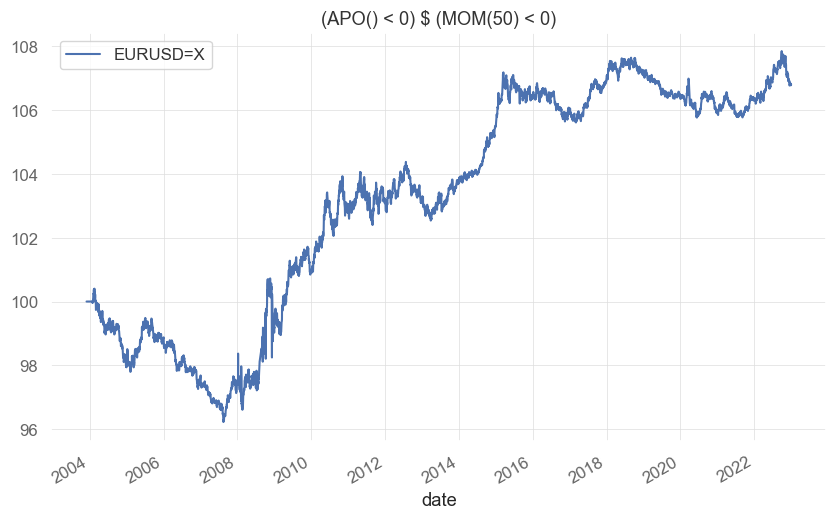

In [6]:
individual = top10.individual.iloc[0]
pf = ga.get_individual_performance(individual)
pf.value().plot()
plt.title(individual)
plt.show()

### __Next Steps__

Before going live, there is a list of things we'll have to do on our selected individual.

First, we need to test it for robustness to avoid data mining bias. I have a separate repo (https://github.com/chickenopoulos/robustness-testing) dedicated to this, which includes a list of tests to evaluate the robustness of the individual.

Then, we will have to define the bet sizing approach - i.e. whether it'll be simple cumulative, fixed, scaling, kelly/half kelly or else.

Finally, we have to define the risk profile of the individual. This can be done from the Robustness Testing framework (specifically the Monte Carlo Tests). This step is crucial as it will allow us to tell when it's the correct time to **ditch** the individual in case the performance goes south. In essence, this step involves setting up the kill switch for the mined strategies by defining the right performance expectations in terms of Sharpe, Max DD and/or else.